In [1]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# 1. 경로 설정
# -----------------------------
CLASS_PATHS = {
    "slsim_lenses": "/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses",
    "slsim_nonlenses": "/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses",
    "hsc_lenses": "/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses",
    "hsc_nonlenses": "/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses",
}

# -----------------------------
# 2. 파일 리스트와 라벨 준비
# -----------------------------
def prepare_file_list():
    files, labels = [], []
    for cls, path in CLASS_PATHS.items():
        if "nonlenses" in cls:  # 먼저 비렌즈 확인
            label = 0
        else:                   # 그 외는 렌즈
            label = 1
        for f in Path(path).glob("*.fits"):
            files.append(str(f))
            labels.append(label)
    return np.array(files), np.array(labels)


files, labels = prepare_file_list()


# -----------------------------
# 3. Train/Val/Test Split
# -----------------------------
# 첫 번째 split: test 15%
train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels, test_size=0.15, stratify=labels, random_state=42
)

# 두 번째 split: 남은 데이터 중 15/85 ≈ 0.1765 → 15%를 유지하려면 0.1765 비율로 split
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1765, stratify=train_labels, random_state=42
)

# -----------------------------
# 4. PyTorch Dataset 정의
# -----------------------------
class LensDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # FITS 이미지 로드
        with fits.open(self.file_list[idx]) as hdul:
            img = np.array(hdul[1].data[0][1]).reshape(41, 41)

        # 정규화: Z-score
        img = (img - img.mean()) / (img.std() + 1e-8)

        # 채널 차원 추가 (1, H, W)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # 추가 변환 (증강 등)
        if self.transform:
            img = self.transform(img)

        return img, label

# -----------------------------
# 5. DataLoader 준비
# -----------------------------
train_dataset = LensDataset(train_files, train_labels)
val_dataset = LensDataset(val_files, val_labels)
test_dataset = LensDataset(test_files, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 699975, Val: 150025, Test: 150000


In [2]:
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# -----------------------------
# 기존 train_dataset, val_dataset, test_dataset이 있다고 가정
# -----------------------------

# 전체 train 데이터 중 10% 인덱스만 선택
num_samples = int(len(train_dataset) * 0.1)
indices = np.random.choice(len(train_dataset), num_samples, replace=False)

train_subset = Subset(train_dataset, indices)

# DataLoader 준비
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 10 * 10, 64)  # 41x41 -> 20x20 -> flatten
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (1,41,41) -> (16,20,20)
        x = self.pool(F.relu(self.conv2(x)))  # (16,20,20) -> (32,10,10)
        x = x.view(-1, 32 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [4]:
import time
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 5

print(f"Device: {device}")
print(f"Total batches - Train: {len(train_loader)}, Val: {len(val_loader)}")
print("="*60)

for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    # -----------------------------
    # Training Phase
    # -----------------------------
    for batch_idx, (imgs, labels) in enumerate(train_loader, 1):
        imgs, labels = imgs.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Collect predictions for accuracy
        preds = (outputs > 0.5).int()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())

        # Progress logging every 100 batches
        if batch_idx % 100 == 0:
            print(f"[Epoch {epoch+1}/{EPOCHS} | Batch {batch_idx}/{len(train_loader)}] "
                  f"Current Train Loss: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds) * 100

    # -----------------------------
    # Validation Phase
    # -----------------------------
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).int()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds) * 100

    elapsed = time.time() - start_time

    # -----------------------------
    # Epoch Summary Logging
    # -----------------------------
    print("="*60)
    print(f"Epoch {epoch+1}/{EPOCHS} completed in {elapsed:.2f}s")
    print(f"  Train Loss : {avg_train_loss:.4f} | Train Acc : {train_acc:.2f}%")
    print(f"  Val   Loss : {avg_val_loss:.4f} | Val   Acc : {val_acc:.2f}%")
    print("="*60)


Device: cuda
Total batches - Train: 1094, Val: 2345
[Epoch 1/5 | Batch 100/1094] Current Train Loss: 0.5592
[Epoch 1/5 | Batch 200/1094] Current Train Loss: 0.4359
[Epoch 1/5 | Batch 300/1094] Current Train Loss: 0.4298
[Epoch 1/5 | Batch 400/1094] Current Train Loss: 0.3707
[Epoch 1/5 | Batch 500/1094] Current Train Loss: 0.4215
[Epoch 1/5 | Batch 600/1094] Current Train Loss: 0.3183
[Epoch 1/5 | Batch 700/1094] Current Train Loss: 0.3261
[Epoch 1/5 | Batch 800/1094] Current Train Loss: 0.4123
[Epoch 1/5 | Batch 900/1094] Current Train Loss: 0.5042
[Epoch 1/5 | Batch 1000/1094] Current Train Loss: 0.3461
Epoch 1/5 completed in 1275.05s
  Train Loss : 0.4403 | Train Acc : 78.85%
  Val   Loss : 0.3771 | Val   Acc : 82.96%
[Epoch 2/5 | Batch 100/1094] Current Train Loss: 0.4594
[Epoch 2/5 | Batch 200/1094] Current Train Loss: 0.4689
[Epoch 2/5 | Batch 300/1094] Current Train Loss: 0.3432
[Epoch 2/5 | Batch 400/1094] Current Train Loss: 0.4058
[Epoch 2/5 | Batch 500/1094] Current Train Lo

In [8]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.eval()
all_labels = []
all_preds = []
all_probs = []

start_time = time.time()
total_batches = len(test_loader)
print(f"Starting evaluation on Test Set ({total_batches} batches)...")
print("="*60)

with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_loader, 1):
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(imgs)
        probs = outputs.squeeze().cpu().numpy()
        preds = (outputs > 0.5).int().squeeze().cpu().numpy()

        # Collect labels & predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

        # Progress logging every 100 batches
        if batch_idx % 100 == 0 or batch_idx == total_batches:
            print(f"[Batch {batch_idx}/{total_batches}] Processed")

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# 기본 지표 계산
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

elapsed = time.time() - start_time

print("="*60)
print(f"Test Evaluation Completed in {elapsed:.2f}s")
print(f"Total Samples : {len(all_labels)}")
print("-"*60)
print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC-AUC       : {auc:.4f}")
print("="*60)


Starting evaluation on Test Set (2344 batches)...
[Batch 100/2344] Processed
[Batch 200/2344] Processed
[Batch 300/2344] Processed
[Batch 400/2344] Processed
[Batch 500/2344] Processed
[Batch 600/2344] Processed
[Batch 700/2344] Processed
[Batch 800/2344] Processed
[Batch 900/2344] Processed
[Batch 1000/2344] Processed
[Batch 1100/2344] Processed
[Batch 1200/2344] Processed
[Batch 1300/2344] Processed
[Batch 1400/2344] Processed
[Batch 1500/2344] Processed
[Batch 1600/2344] Processed
[Batch 1700/2344] Processed
[Batch 1800/2344] Processed
[Batch 1900/2344] Processed
[Batch 2000/2344] Processed
[Batch 2100/2344] Processed
[Batch 2200/2344] Processed
[Batch 2300/2344] Processed
[Batch 2344/2344] Processed
Test Evaluation Completed in 737.68s
Total Samples : 150000
------------------------------------------------------------
Test Accuracy : 0.8623
Precision     : 0.8544
Recall        : 0.8734
F1 Score      : 0.8638
ROC-AUC       : 0.9394


Extracting a random batch from test set for visualization...
Running model inference for sample visualization...
Sample Predictions:
[Sample 1] True: 0 | Pred: 0 | Prob: 0.0471
[Sample 2] True: 0 | Pred: 0 | Prob: 0.0076
[Sample 3] True: 0 | Pred: 0 | Prob: 0.0036
[Sample 4] True: 0 | Pred: 0 | Prob: 0.1836
[Sample 5] True: 0 | Pred: 0 | Prob: 0.1993


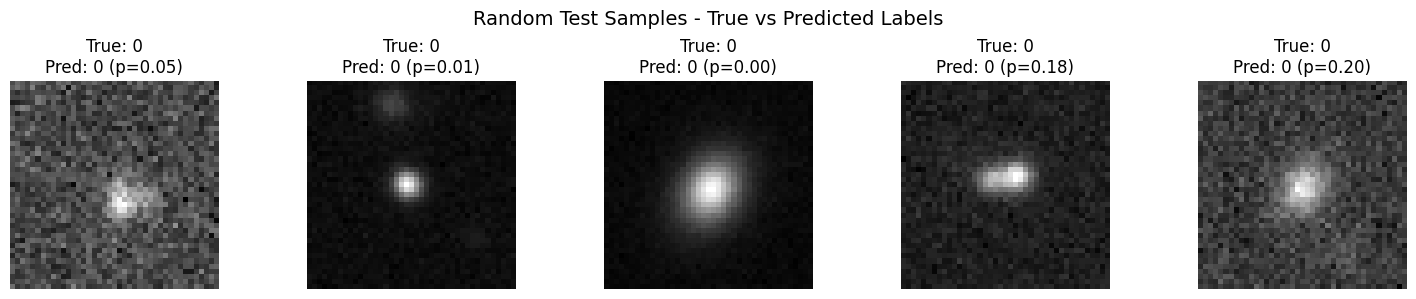

In [9]:
import matplotlib.pyplot as plt

model.eval()

# -----------------------------
# 1. 샘플 데이터 추출
# -----------------------------
print("="*60)
print("Extracting a random batch from test set for visualization...")
sample_imgs, sample_labels = next(iter(test_loader))
sample_imgs = sample_imgs.to(device)

# -----------------------------
# 2. 모델 예측
# -----------------------------
print("Running model inference for sample visualization...")
sample_outputs = model(sample_imgs).detach().cpu().numpy().squeeze()
sample_preds = (sample_outputs > 0.5).astype(int)

# -----------------------------
# 3. 로깅: 각 샘플 요약
# -----------------------------
print("="*60)
print("Sample Predictions:")
for i in range(5):
    print(f"[Sample {i+1}] True: {sample_labels[i].item()} | "
          f"Pred: {sample_preds[i]} | "
          f"Prob: {sample_outputs[i]:.4f}")
print("="*60)

# -----------------------------
# 4. 시각화
# -----------------------------
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(sample_imgs[i][0].cpu(), cmap="gray")
    axes[i].set_title(
        f"True: {sample_labels[i].item()}\nPred: {sample_preds[i]} (p={sample_outputs[i]:.2f})"
    )
    axes[i].axis("off")

plt.suptitle("Random Test Samples - True vs Predicted Labels", fontsize=14)
plt.tight_layout()
plt.show()
